## Import and data loader

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

def load_polar(file):
    lidar = np.load(file)
    return  from_polar(preprocess(lidar).astype('float32'))



## Load Caccia helper functions

In [2]:

def from_polar(velo):
    angles = np.linspace(0, np.pi * 2, velo.shape[-1])
    dist, z = velo[:, 0], torch.Tensor(velo[:, 1])
    x = torch.Tensor(np.cos(angles)).unsqueeze(0).unsqueeze(0) * dist
    y = torch.Tensor(np.sin(angles)).unsqueeze(0).unsqueeze(0) * dist
    out = torch.stack([x,y,z], dim=1)
    return out

def to_polar(velo):
    if len(velo.shape) == 4:
        velo = velo.permute(1, 2, 3, 0)
    if velo.shape[2] > 4:
        assert velo.shape[0] <= 4
        velo = velo.permute(1, 2, 0, 3)
        switch=True
    else:
        switch=False
    # assumes r x n/r x (3,4) velo
    dist = torch.sqrt(velo[:, :, 0] ** 2 + velo[:, :, 1] ** 2)
    # theta = np.arctan2(velo[:, 1], velo[:, 0])
    out = torch.stack([dist, velo[:, :, 2]], dim=2)
    if switch:
        out = out.permute(2, 0, 1, 3)
    if len(velo.shape) == 4: 
        out = out.permute(3, 0, 1, 2)
    return out

def to_polar_np(velo):
    if len(velo.shape) == 4:
        velo = velo.transpose(1, 2, 3, 0)
    if velo.shape[2] > 4:
        assert velo.shape[0] <= 4
        velo = velo.transpose(1, 2, 0, 3)
        switch=True
    else:
        switch=False
    # assumes r x n/r x (3,4) velo
    dist = np.sqrt(velo[:, :, 0] ** 2 + velo[:, :, 1] ** 2)
    # theta = np.arctan2(velo[:, 1], velo[:, 0])
    out = np.stack([dist, velo[:, :, 2]], axis=2)
    if switch:
        out = out.transpose(2, 0, 1, 3)
    if len(velo.shape) == 4: 
        out = out.transpose(3, 0, 1, 2)
    return out

def remove_zeros(pc):
    xx = torch.FloatTensor(pc)
    if xx.dim() == 3: 
        xx = xx.unsqueeze(0)

    iters = 0
    pad = 2
    ks = 5
    while (xx[:, 0] == 0).sum() > 0 : 
        if iters  > 100:
            raise ValueError()
            ks += 2
            pad += 1
        
        mask = (xx[:, 0] == 0).unsqueeze(1).float()
        out_a = F.max_pool2d(xx[:, 0], ks, padding=pad, stride=1)
        out_b = -F.max_pool2d(-xx[:, 1], ks, padding=pad, stride=1)
        #out_b_ = (xx[:, 1]).min(dim=-1, keepdim=True)[0].expand_as(out_b)
        #out_b = torch.cat([out_b_[:, :10], out_b[:, 10:]], dim=1)
        out_b = out_b.expand_as(out_a)
        out = torch.stack([out_a, out_b], dim=1)
        mask = (xx[:, 0] == 0).unsqueeze(1)
        mask = mask.float()
        xx = xx * (1 - mask) + (mask) * out
        iters += 1

    return xx.cpu().data.numpy()


def preprocess(dataset):
    min_a, max_a = -41.1245002746582,   36.833248138427734
    min_b, max_b = -25.833599090576172, 30.474000930786133
    min_c, max_c = -2.3989999294281006, 0.7383332848548889
    dataset = dataset[:, 5:45]

    mask = np.maximum(dataset[:, :, :, 0] < min_a, dataset[:, :, :, 0] > max_a)
    mask = np.maximum(mask, np.maximum(dataset[:, :, :, 1] < min_b, dataset[:, :, :, 1] > max_b))
    mask = np.maximum(mask, np.maximum(dataset[:, :, :, 2] < min_c, dataset[:, :, :, 2] > max_c))
    
    dist = dataset[:, :, :, 0] ** 2 + dataset[:, :, :, 1] ** 2
    mask = np.maximum(mask, dist < 7)

    dataset = dataset * (1 - np.expand_dims(mask, -1))
    dataset /= np.absolute(dataset).max()

    dataset = to_polar_np(dataset).transpose(0, 3, 1, 2)
    previous = (dataset[:, 0] == 0).sum()

    remove = []
    for i in range(dataset.shape[0]):
        #print('processing {}/{}'.format(i, dataset.shape[0]))
        try:
            pp = remove_zeros(dataset[i]).squeeze(0)
            dataset[i] = pp
        except:
            print('removing %d' % i)
            remove += [i]

    for i in remove:
        dataset = np.concatenate([dataset[:i-1], dataset[i+1:]], axis=0)

    return dataset[:, :, :, ::2]


## Visualize

removing 42
removing 153


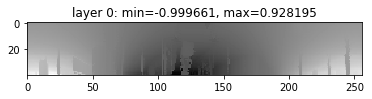

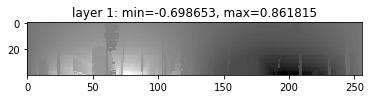

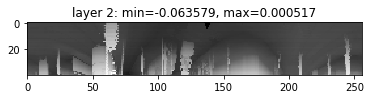

In [8]:
import matplotlib.pyplot as plt
from matplotlib import cm

lidar = load_polar(names[0]).numpy()
for i in range(3):
    title = 'layer %d: min=%f, max=%f'%(i,np.min(lidar[:,i,:,:]),np.max(lidar[:,i,:,:]))
    plt.imshow(lidar[0,i,:,:], cmap=cm.gray)
    plt.title(title)
    #plt.gcf().set_size_inches(16,16)
    plt.show()
del lidar #free memory space

## VAE process and loss

In [14]:
class VAE(nn.Module):
    def __init__(self, batch_size): #specify parameter functions to train 
        super(VAE, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 3, 4, 2, 1, bias=False)
        self.conv2 = nn.Conv2d(3, 3, 4, 2, 1, bias=False)
        self.conv3 = nn.Conv2d(3, 3, 4, 2, 1, bias=False)
        self.conv4 = nn.Conv2d(3, 3, (3,4), 2, (0,1), bias=False)
        self.conv5 = nn.Conv2d(3, 3, (2,16), 1, 0, bias=False)
        self.munet = nn.Linear(batch_size*3,batch_size*3)
        self.varnet = nn.Linear(batch_size*3,batch_size*3)
        #size 5*16 chosen due to memory constaints on up2
        self.upsample1 = nn.Linear(batch_size*3, batch_size*3*5*16) 
        self.upsample2 = nn.Linear(batch_size*3*5*16,batch_size*3*40*256)
        
    def encode_pre_amrr(self, t): #VAE up to AMRR step
        #instantiate, [10, 3, 40, 256]
        relu = nn.LeakyReLU(0.2, inplace=True)
        norm = nn.BatchNorm2d(3)
        t=t
        #layer 1, to [10, 3, 20, 128]
        t = self.conv1(t) #learned parameter 
        t = relu(t)
        #layer 2, to [10, 3, 10, 64]
        t = self.conv2(t)
        t = norm(t)
        t = relu(t)
        #output
        return t
    
    def encode_post_amrr(self, t): #VAE from AMRR to Z parameters
        #instantiate
        relu = nn.LeakyReLU(0.2, inplace=True)
        norm = nn.BatchNorm2d(3)
        t=t
        #layer 3, to[10, 3, 5, 32]
        t = self.conv3(t) #learned parameter 
        t = norm(t)
        t = relu(t)
        #layer 4, to [10, 3, 2, 16]
        t = self.conv4(t)
        t = norm(t)
        t = relu(t)
        #layer 5, to [10, 3, 1, 1]
        t = self.conv5(t)
        #output
        #mu, logvar = torch.chunk(z,2,dim=1) #per Caccia
        #(_, C, H, W) = t.data.size()
        #t = t.view( -1 , C * H * W)
        t = t.view( 1, -1)
        mu = self.munet(t)
        logvar = self.varnet(t)
        return mu, logvar
    
    def reparameterize(self, mu, logvar): #Z parameters to sample
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        z = eps.mul(std).add_(mu)
        return z
    
    def decode(self, z): #sample to original data
        #instantiate
        relu = nn.LeakyReLU(0.2, inplace=True)
        #norm = nn.BatchNorm1d(1,2400)
        z=z
        #upsample 1
        z = self.upsample1(z)
        #z = norm(z)
        z = relu(z)
        #upsample 2
        z = self.upsample2(z)
        z = torch.sigmoid(z) #relu will not work as image may have neg values
        return z
    
    def forward(self, x, batch_size): #full vae forward path
        print('encoding to amrr')
        x_amrr = self.encode_pre_amrr(x)
        print('encoding to z')
        mu, logvar = self.encode_post_amrr(x_amrr)
        print('reparameterizing')
        z = self.reparameterize(mu, logvar)
        print('decoding')
        x_pred = self.decode(z)
        x_pred = x_pred.view(batch_size,3,40,256) 
        return x_pred, mu, logvar 
        
def loss_func(sample, data, mu, logvar):
    recon_loss = F.binary_cross_entropy(sample,data)
    kl_loss = -0.5*torch.sum(1+logvar-mu.pow(2)-logvar.exp(),dim=1)
    loss = recon_loss + kl_loss
    return loss
        
    
    

## Training

In [27]:
print('loading data')
names = ['lidar_val.npz','lidar_val.npz']
batch_size=5
loader = DataLoader(load_polar(names[0]), batch_size = batch_size, shuffle=True, drop_last=True) 

#the vae trains the convolution layers
network = VAE(batch_size)
lr = 0.00001
solver = optim.Adam(network.parameters(), lr=lr)
#network.eval() #changes batch normalization behavior

training_loss = []
#epoch_loss = []
#epochs = 3
#for epoch in range(epochs):
for batch in loader:
    #initialization
    solver.zero_grad()
        
    #vae foreward
    print('running network')
    pred, mu, logvar = network(batch, batch_size)
    print('computing loss')
    loss = loss_func(pred, batch, mu, logvar)
    training_loss.append(loss)
    print('loss: %.3f'%loss)
    
    #vae backwars
    print('computing gradient')
    loss.backward()
    print('stepping')
    solver.step()
    print('updated')
    print(' ')

    


loading data
removing 42
removing 153
running network
encoding to amrr
encoding to z
reparameterizing
decoding
computing loss
loss: 1.095
computing gradient
stepping
updated
 
running network
encoding to amrr
encoding to z
reparameterizing
decoding
computing loss
loss: 1.144
computing gradient
stepping
updated
 
running network
encoding to amrr
encoding to z
reparameterizing
decoding
computing loss
loss: 1.103
computing gradient
stepping
updated
 
running network
encoding to amrr
encoding to z
reparameterizing
decoding
computing loss
loss: 1.060
computing gradient
stepping
updated
 
running network
encoding to amrr
encoding to z
reparameterizing
decoding
computing loss
loss: 1.071
computing gradient
stepping
updated
 
running network
encoding to amrr
encoding to z
reparameterizing
decoding
computing loss
loss: 1.012
computing gradient
stepping
updated
 
running network
encoding to amrr
encoding to z
reparameterizing
decoding
computing loss
loss: 1.086
computing gradient
stepping
update

## Plot

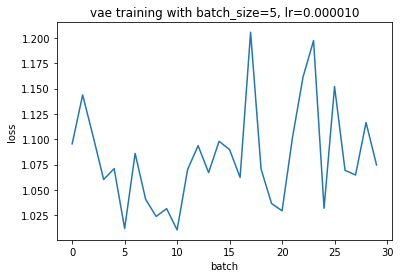

In [28]:
training_loss = np.array(training_loss)

plt.plot(range(len(training_loss)),training_loss)
#plt.plot(range(num_epochs),testing_loss)
#plt.legend(['Training','Testing'])
plt.xlabel('batch')#'epoch')
plt.ylabel('loss')
#titlestr = 'Training with %d %% data at %.2f learning rate, K_optimum=%d '%(TrainFrac*100, lr,K_opt)
plt.title('vae training with batch_size=%d, lr=%f'%(batch_size,lr))
plt.show()
#plt.savefig('training_loss.png')